# Titanic Dataset

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [118]:
raw_train = pd.read_csv("../input/titanic/train.csv")
raw_test = pd.read_csv("../input/titanic/test.csv")

# Verify import
raw_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [119]:
raw_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

From the above, we can see that passengerId gives us nothing to work with on predicting whether the passenger will live or die - it's just a unique number identifying them. This is about as helpful as their name. Their passengerId requires less cleaning so we will use that to differentiate folks. The ticket appears less important due to the number of unique values as well. We can probably get more pertinent information by looking at the ticket class and/or fare price.<br><br>
Let's see what some of the unique values are.

In [120]:
raw_train["Age"].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [121]:
raw_train["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [122]:
raw_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The cabin is mostly empty, so we can disregard that. The fare will give us a good idea as to the "class" or wealth level of the passenger. Ticket number won't be important, so we can remove. The wealth level may be a feature of interest so we'll keep the fare and Pclass to examine this<br><br>
The age on the other hand is mostly there. We can impute some values to fill it out.<br><br>
Let's explore the data a bit before we continue.

## EDA

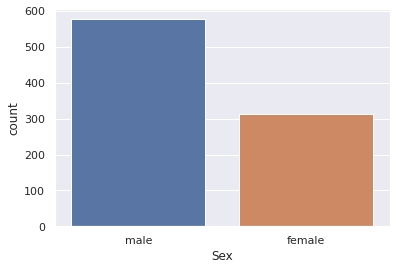

In [123]:
sns.countplot(x="Sex", data=raw_train)

There appear to be about twice the number of males as there are females on board the training set. We'll keep this in mind as we examine the impact of sex on survivability.

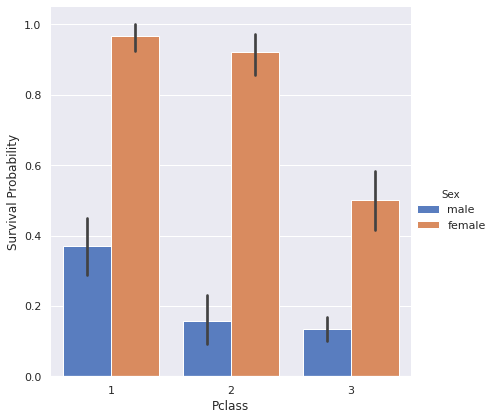

In [124]:
sns.set(style="darkgrid")

plot1 = sns.catplot(x="Pclass", y="Survived",
                    hue="Sex", data=raw_train,
                    height=6, kind="bar", 
                    palette="muted")
plot1.despine(left=True)
plot1.set_ylabels("Survival Probability")

We can see that females had a much higher chance of surviving over men in all classes - though there is a considerable survival uptick with men in first class.

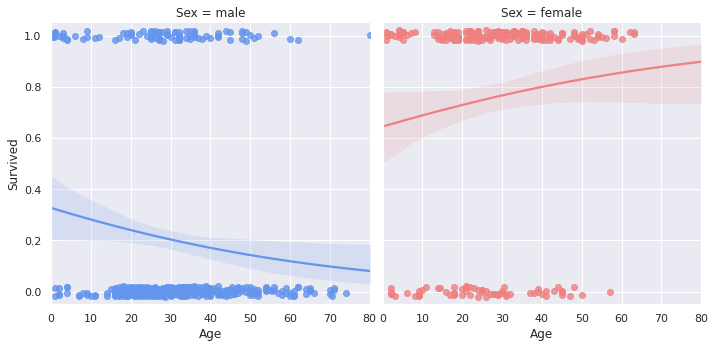

In [125]:
# Creating color palettes
pal = dict(male="#6495ED", female="#F08080")

# Survival probability as a function of age and sex
plot2 = sns.lmplot(x="Age", y="Survived", 
                   col="Sex", hue="Sex", 
                   data=raw_train, palette=pal, 
                   y_jitter=.02, logistic=True, 
                   truncate=False)
plot2.set(xlim=(0, 80), ylim=(-.05, 1.05))

The above shows that the chance of survival seemed to decrease in men as they got older, while women saw an uptick in survival.

In [126]:
# We'll drop these three columns because we can obtain the same/better feature information with the other columns
train_1 = raw_train.drop(["Cabin", "Ticket", "Name"], axis=1)

Now we need to clean the df a bit before we impute values. The cleaning we will do is:
* Engineer a new feature "Relatives" out of SibSp and Parch columns.
* Encode the Sex and Embarked values with a dummy encoder
* Scale/normalize the Fare
    * The Age will remain as is to assist with EDA - we can get a sense for how much one pays with a scaled fare but not as much with a scaled/normalized age.

## Feature Engineering

In [127]:
data = [train_1]
for dataset in data:
    dataset["Relatives"] = dataset["SibSp"] + dataset["Parch"]

In [128]:
train_2 = train_1.drop(["SibSp", "Parch"], axis=1)

In [129]:
train_2.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Relatives
0,1,0,3,male,22.0,7.2500,S,1
1,2,1,1,female,38.0,71.2833,C,1
2,3,1,3,female,26.0,7.9250,S,0
3,4,1,1,female,35.0,53.1000,S,1
4,5,0,3,male,35.0,8.0500,S,0


## Encoding Categorical Features

Before we encode, we need to fill in the few missing values in the Embarked column. Since there are only two (2/891) we can fill these in with the mode. 

In [130]:
train_2["Embarked"] = train_2.fillna(train_2["Embarked"].mode())

In [131]:
train_2.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
Fare             0
Embarked         0
Relatives        0
dtype: int64

In [ ]:
cat_columns = train_2["Sex", "Embarked"]


In [ ]:
# To impute our values in a semi-educated way. we'll split our data into two segments
# and run a simple linear regression to "predict" the ages.

raw_train_ages = raw_train.loc[raw_train["Age"].isna() == False]

In [ ]:
raw_train_ages.isna().sum()

In [ ]:
raw_train_no_ages = raw_train.loc[raw_train["Age"].isna() == True]

In [ ]:
raw_train_no_ages.isna().sum()

In [ ]:
X_raw_train_ages = raw_train_ages.drop("Age", axis=1)

In [ ]:
y_raw_train_ages = raw_train_ages.Age

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_ages = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
            },
            cv=5, 
            scoring='neg_mean_squared_error', 
            verbose=10, 
            n_jobs=-1)

rf_output = rf_ages.fit(X_raw_train_ages, y_raw_train_ages)

print(rf_output.best_params_)

##################### I need to clean my df first :/